In [1]:
from blg_strain.classes import BandStructure
from blg_strain.microscopic import feq_func
from blg_strain.macroscopic import _M_bands, _M_integral, _M_integral_by_parts
from blg_strain.utils.const import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [3]:
bs_dict = dict()

Delta = 0.01
deltas = np.array([-0.05, -0.01, 0, 0.01, 0.05])

for delta in deltas:
    bs = BandStructure(delta=delta, Delta=Delta, ham='4x4')
    
    bs.calculate(1000,1000)
    
    bs_dict[str(delta)] = bs

In [4]:
bs.save('E:\\sBLG_data\\bs.npz')

In [5]:
bs = BandStructure.load('E:\\sBLG_data\\bs.npz')

# Bands

<IPython.core.display.Javascript object>


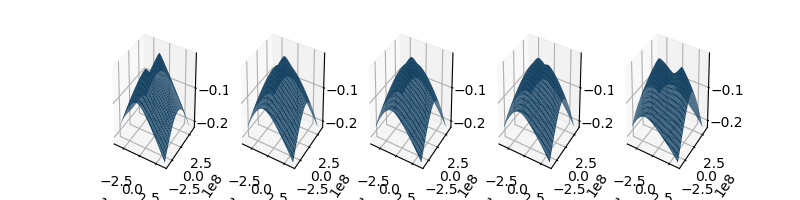

In [6]:
fig = plt.figure(figsize=(8, 2))
axes = []
axes.append(fig.add_subplot(151, projection='3d'))
axes.append(fig.add_subplot(152, projection='3d'))
axes.append(fig.add_subplot(153, projection='3d'))
axes.append(fig.add_subplot(154, projection='3d'))
axes.append(fig.add_subplot(155, projection='3d'))

for i, (k, bs) in enumerate(bs_dict.items()):
    axes[i].plot_surface(bs.Kx, bs.Ky, bs.E[1])

In [7]:
from blg_strain.utils.plotting import plot_bands_3d

<IPython.core.display.Javascript object>


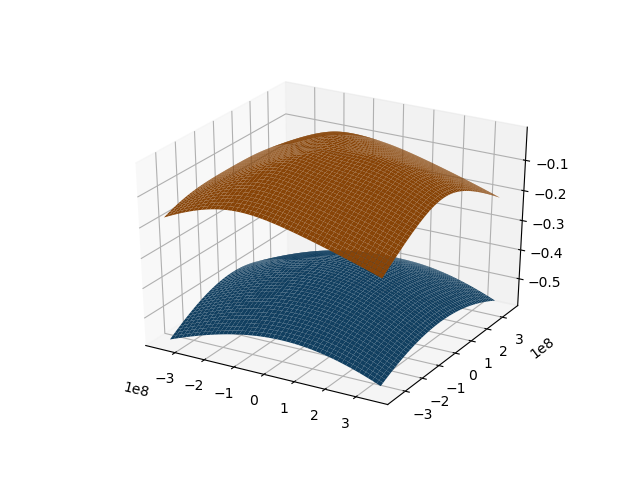

(<Figure size 640x480 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x20d1050bd48>)

In [8]:
bs = bs_dict['0.0']
plot_bands_3d(bs.Kx, bs.Ky, bs.E, which=[0,1])

<IPython.core.display.Javascript object>


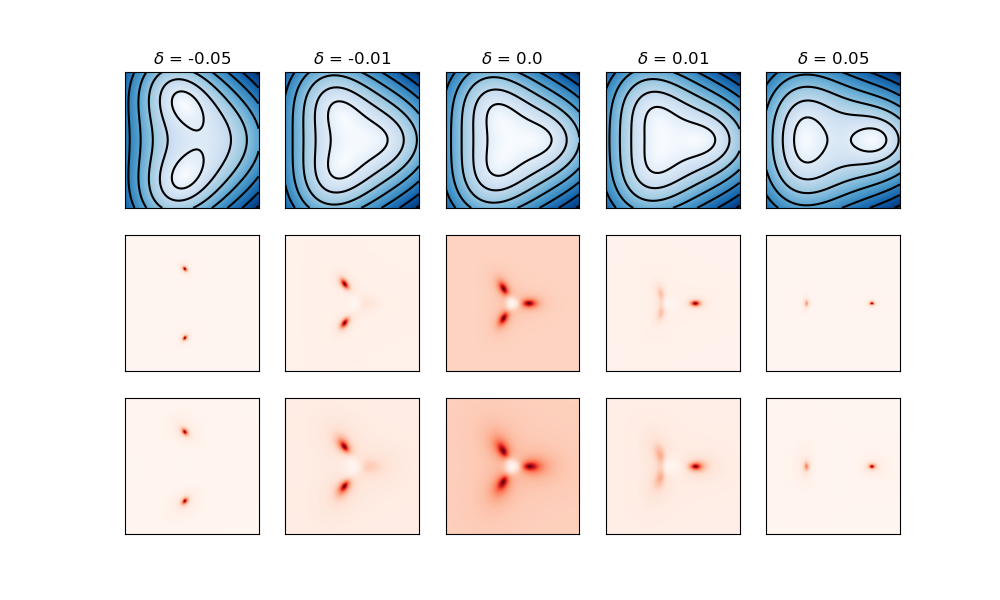

In [9]:
n=2

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))

for i, (k, bs) in enumerate(bs_dict.items()):
    ax[0,i].pcolormesh(bs.Kx, bs.Ky, bs.E[n], cmap='Blues')
    ax[0,i].contour(bs.Kx, bs.Ky, bs.E[n], colors='k')
    
    ax[1,i].pcolormesh(bs.Kx, bs.Ky, bs.Omega[n], cmap='Reds')
#     ax[1,i].contour(bs.Kx, bs.Ky, bs.Omega[1], colors='k')
    
    ax[2,i].pcolormesh(bs.Kx, bs.Ky, bs.Mu[n], cmap='Reds')
#     ax[2,i].contour(bs.Kx, bs.Ky, bs.Mu[1], colors='k')
    
    ax[0,i].set_title(r'$\delta$ = {}'.format(bs.kwargs['delta']))
    for j in range(3):
        ax[j,i].set_xticks([])
        ax[j,i].set_yticks([])

# Calculating versus many parameters

For each $\delta$ and $\Delta$, band structure needs to be recalculated. For each $E_F$ and $T$, we calculate the Fermi function `feq_func(E, EF, T)` which does not require recalculation of the bands. Then given all of this, we can calculate the magnetization (not yet dotted with electric field) for a combination of $\delta$, $\Delta$, $E_F$ and $T$.

In [26]:
bs.get_feq(EF=0.006, T=0)

In [27]:
bs.get_M_over_E()

array([3.26237624e-02, 9.44995566e-17])

In [28]:
bs.get_M([100, 0])

3.262376239463363

In [29]:
bs.get_nD()

In [14]:
bs.__dict__

{'delta': 0.05,
 'Delta': 0.01,
 'ham': '4x4',
 'K': <blg_strain.classes.Valley at 0x20d7bf57988>,
 'Kp': <blg_strain.classes.Valley at 0x20d7bf57948>,
 'gamma4': 0.0,
 'dab': 0.0,
 'M_over_E': array([3.26237624e-02, 9.44995566e-17]),
 'n': 192017859810069.88,
 'D': 31829485.28894113}

In [15]:
bs.save('E:\\sBLG_data\\bs.npz')

# Zero temperature, constant strain = 0.5%, changing $\Delta$ and $E_F$

In [33]:
T = 0
delta = 0.005
Deltas = np.linspace(-0.05, 0.05, 41)
EFs = np.linspace(-0.05, 0.05, 61)

In [34]:
Deltas[:5], EFs[:5]

(array([-0.05  , -0.0475, -0.045 , -0.0425, -0.04  ]),
 array([-0.05      , -0.04833333, -0.04666667, -0.045     , -0.04333333]))

At 1 min/band structure and 5 seconds per $E_F$, this would take 41 min for all the band structures and then ~5/60 * 61 * 41 = 210 minutes for the magnetization, etc. Band structures together take ~20 GB and the magnetization should be negligible (we won't save the Fermi occupation).

In [35]:
import datetime

In [36]:
print(datetime.datetime.now())

2020-07-02 18:02:23.612960


In [37]:
for Delta in Deltas:
    print(datetime.datetime.now(), 'Delta ', Delta)
    M_over_Es = np.empty((*EFs.shape, 2))
    ns = np.empty_like(EFs)
    Ds = np.empty_like(EFs)
    
    bs = BandStructure(delta=delta, Delta=Delta, ham='4x4')
    bs.calculate(1000,1000)
    
    bs.save('E:\\sBLG_data\\20200702\\bs_d{}_D{}.npz'.format(delta, Delta))
    
    print(datetime.datetime.now(), 'Starting EF loop...')
    for j, EF in enumerate(EFs):
        bs.get_feq(EF=EF, T=T)
        M_over_Es[j] = bs.get_M_over_E()
        ns[j], Ds[j] = bs.get_nD()
    print(datetime.datetime.now(), 'Finished EF loop...')
        
    d = dict(Deltas=Delta, EFs=EFs, M_over_Es=M_over_Es, ns=ns, Ds=Ds)
    
    np.savez('E:\\sBLG_data\\20200702\\versusEF_d{}_D{}_T{}.npz'.format(delta, Delta, T), **d)    

2020-07-02 18:02:24.252453 Delta  -0.05
2020-07-02 18:02:54.031880 Starting EF loop...
2020-07-02 18:05:06.474059 Finished EF loop...
2020-07-02 18:05:06.476059 Delta  -0.0475
2020-07-02 18:05:36.543830 Starting EF loop...
2020-07-02 18:07:48.960030 Finished EF loop...
2020-07-02 18:07:48.962029 Delta  -0.045000000000000005
2020-07-02 18:08:19.292774 Starting EF loop...
2020-07-02 18:10:32.957258 Finished EF loop...
2020-07-02 18:10:32.959257 Delta  -0.0425
2020-07-02 18:11:03.690341 Starting EF loop...
2020-07-02 18:13:19.809410 Finished EF loop...
2020-07-02 18:13:19.812420 Delta  -0.04
2020-07-02 18:13:49.498463 Starting EF loop...
2020-07-02 18:16:02.925166 Finished EF loop...
2020-07-02 18:16:02.928164 Delta  -0.037500000000000006
2020-07-02 18:16:32.613174 Starting EF loop...
2020-07-02 18:18:48.391460 Finished EF loop...
2020-07-02 18:18:48.394447 Delta  -0.035
2020-07-02 18:19:18.072225 Starting EF loop...
2020-07-02 18:21:34.502127 Finished EF loop...
2020-07-02 18:21:34.52719

# Reload data and plot

In [1]:
from blg_strain.classes import BandStructure
from blg_strain.microscopic import feq_func
from blg_strain.macroscopic import _M_bands, _M_integral, _M_integral_by_parts
from blg_strain.utils.const import *

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [3]:
T = 0
delta = 0.005
Deltas = np.linspace(-0.05, 0.05, 41)
EFs = np.linspace(-0.05, 0.05, 61)

In [4]:
import glob
import os

In [5]:
files = glob.glob('E:\\sBLG_data\\20200702\\*.npz')
files.sort(key=os.path.getmtime)
files[:5]

['E:\\sBLG_data\\20200702\\bs_d0.005_D-0.05.npz',
 'E:\\sBLG_data\\20200702\\versusEF_d0.005_D-0.05_T0.npz',
 'E:\\sBLG_data\\20200702\\bs_d0.005_D-0.0475.npz',
 'E:\\sBLG_data\\20200702\\versusEF_d0.005_D-0.0475_T0.npz',
 'E:\\sBLG_data\\20200702\\bs_d0.005_D-0.045000000000000005.npz']

In [6]:
int(len(files)/2)

41

In [7]:
versusEF = np.load(files[1])
EFs = versusEF['EFs']
M_over_E = np.empty((int(len(files)/2), len(EFs), 2))
ns = np.empty((int(len(files)/2), len(EFs)))
Ds = np.empty((int(len(files)/2), len(EFs)))

for i in range(int(len(files)/2)):
    versusEF = np.load(files[2*i + 1])
    M_over_E[i] = versusEF['M_over_Es']
    ns[i] = versusEF['ns']
    Ds[i] = versusEF['Ds']

Only considering the warping of the band structure (i.e. no "Dirac cone tilt" term), the y component of the "M_over_E" vector is noisy and small compared to the x component. This is expected due to the symmetry over y.

In [82]:
M_over_E[:,:,1].max()/M_over_E[:,:,0].max()

5.591559266979531e-15

In [87]:
M_over_E

array([[[ 8.79210353e-03, -2.51627696e-17],
        [ 9.26273179e-03, -8.27500819e-17],
        [ 9.42495944e-03,  8.67111005e-17],
        ...,
        [-9.42495944e-03, -8.68124183e-17],
        [-9.26273179e-03,  4.28299993e-17],
        [-8.79210353e-03,  1.37322481e-17]],

       [[ 7.89586824e-03, -4.77860837e-17],
        [ 8.52804742e-03,  6.81099353e-17],
        [ 8.93049633e-03, -2.25354746e-17],
        ...,
        [-8.93049633e-03,  9.92490078e-17],
        [-8.52804742e-03,  1.60235032e-17],
        [-7.89586824e-03,  2.95284936e-17]],

       [[ 8.00924593e-03, -2.91841402e-17],
        [ 8.04297029e-03, -5.40663754e-18],
        [ 8.58527228e-03,  4.51908043e-17],
        ...,
        [-8.58527228e-03, -6.36639778e-17],
        [-8.04297029e-03, -4.62156570e-18],
        [-8.00924593e-03,  1.66898520e-17]],

       ...,

       [[-8.00924593e-03,  6.40905458e-17],
        [-8.04297029e-03, -6.26699025e-17],
        [-8.58527228e-03, -1.10608387e-17],
        ...,
     

In [120]:
M_over_Ex = M_over_E[:, :, 0] * muB * 1e12 * mu0 / 1e-12 * 1e7

In [121]:
M_over_E[:,:,0].max() 

0.15696967456915173

In [122]:
M_over_Ex.max()

18.293293159095047

In [123]:
M_over_Ex.max() *1e-7 * 1e-12 / mu0 * 100

1.455734015849565e-10

### magnetization due to electric field in x direction

<IPython.core.display.Javascript object>


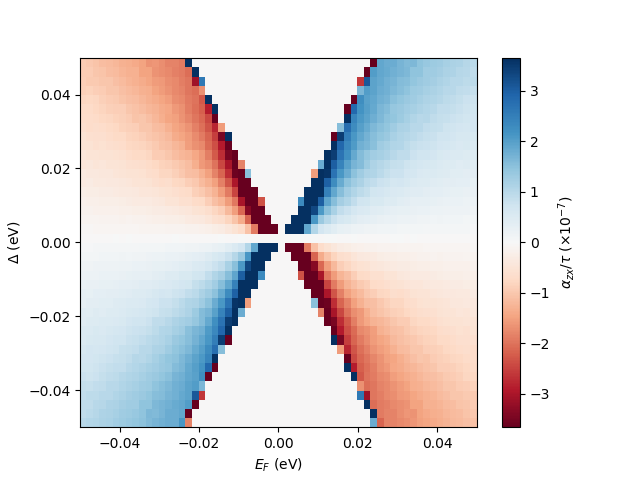

In [125]:
fig, ax = plt.subplots()

factor = 0.2
vmin = M_over_Ex.min() * factor
vmax = M_over_Ex.max() * factor

im = ax.pcolormesh(EFs, Deltas, M_over_Ex, cmap='RdBu', vmin=vmin, vmax=vmax)

ax.set_xlabel('$E_F$ (eV)')
ax.set_ylabel('$\Delta$ (eV)')
cb = plt.colorbar(im, label=r'$\alpha_{zx}/\tau$ ($\times 10^{-7}$)')

In [126]:
fig.savefig('../plots/M_d0.005_Delta_EF.png', bbox_inches='tight')

In [115]:
M_over_Ex.argmax()

1312

In [116]:
np.abs(EFs).argmin()

30

In [117]:
np.abs(Deltas).argmin()

20

In [118]:
Deltas[24], EFs[35]

(0.009999999999999995, 0.008333333333333331)

In [119]:
M_over_Ex[24, 35]

0.4657115776295327

### change variables from $\Delta$, $E_F$ to displacement field $D$ and carrier density $n$

$\Delta=0$ is weird... but magnetization is zero anyway so we shouldn't care.

<IPython.core.display.Javascript object>


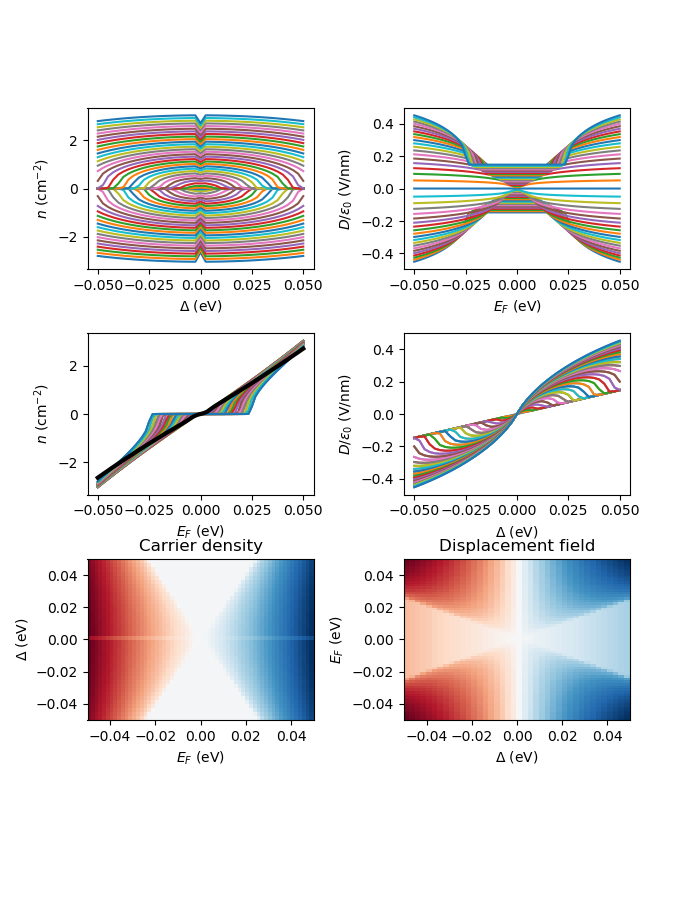

In [127]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(7,9))
ax[0,0].plot(Deltas, ns/1e16);
ax[0,0].set_xlabel('$\Delta$ (eV)')
ax[0,0].set_ylabel('$n$ (cm$^{-2}$)')

ax[1,0].plot(EFs, ns.T/1e16);
ax[1,0].plot(EFs, ns[Deltas==0].T/1e16, '-k', lw=3);
ax[1,0].set_xlabel('$E_F$ (eV)')
ax[1,0].set_ylabel('$n$ (cm$^{-2}$)')

ax[-1,0].pcolormesh(EFs, Deltas, ns/1e16, cmap='RdBu');
ax[-1,0].set_xlabel('$E_F$ (eV)')
ax[-1,0].set_ylabel('$\Delta$ (eV)')
ax[-1,0].set_title('Carrier density')


ax[0,1].plot(EFs, Ds.T/1e9);
ax[0,1].set_xlabel('$E_F$ (eV)')
ax[0,1].set_ylabel('$D/\epsilon_0$ (V/nm)')

ax[1,1].plot(Deltas, Ds/1e9);
ax[1,1].set_xlabel('$\Delta$ (eV)')
ax[1,1].set_ylabel('$D/\epsilon_0$ (V/nm)')

ax[-1,1].pcolormesh(Deltas, EFs, Ds.T/1e9, cmap='RdBu');
ax[-1,1].set_xlabel('$\Delta$ (eV)')
ax[-1,1].set_ylabel('$E_F$ (eV)')
ax[-1,1].set_title('Displacement field')

fig.subplots_adjust(wspace=0.4, hspace=0.4, bottom=0.2)

### magnetization as a function of n, D

Magnetization is given as $M_z/E_x$ in units of $\mu_B$ $\mu$m$^{-2}$ (V/m)$^{-1}$. We can reframe this as a magnetoelectric effect $\mu_0 M_z = \alpha_{zx} E_x$, which gives the magnetoelectric coefficient $\alpha_{zx}$ in units of seconds (note, the magnetization is in 2D, Bohr magneton per unit area rather than unit volume).

In [128]:
1e-6/1e6

1e-12

In [129]:
M_over_Ex.max() * 100

1829.3293159095047

In [132]:
mu0 = 4 * np.pi * 1e-7 # vacuum permeability N/A^2
alpha = M_over_Ex #* mu0 *1e9  # nanoseconds

<IPython.core.display.Javascript object>


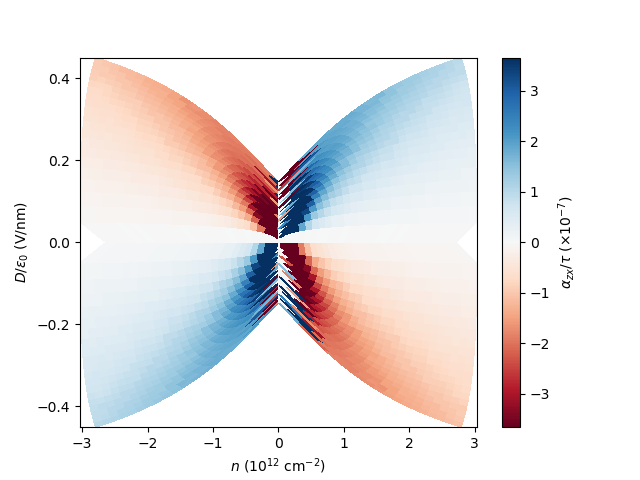

In [134]:
fig, ax = plt.subplots()
factor = 0.2
vmin = alpha.min() * factor
vmax = alpha.max() * factor
im = ax.pcolormesh(ns/1e16, Ds/1e9, alpha, cmap='RdBu', vmin=vmin, vmax=vmax)
ax.set_xlabel('$n$ ($10^{12}$ cm$^{-2}$)')
ax.set_ylabel('$D/\epsilon_0$ (V/nm)')
cb = plt.colorbar(im, label=r'$\alpha_{zx}/\tau$ ($\times 10^{-7}$)')

In [135]:
fig.savefig('../plots/M_d0.005_D_n.png', bbox_inches='tight')

In [17]:
from scipy.interpolate import SmoothBivariateSpline

In [25]:
s = SmoothBivariateSpline(ns.flatten(), Ds.flatten(), alpha.flatten(), kx=2, ky=2)

In [135]:
# d = "dense"
nd = np.linspace(-2, 2, 100)*1e16
Dd = np.linspace(-0.2, 0.2, 100)*1e9

ndm, Ddm = np.meshgrid(nd, Dd)

alphad = s(ndm, Ddm, grid=False)
# alphad = s(ns, Ds, grid=False)

<IPython.core.display.Javascript object>


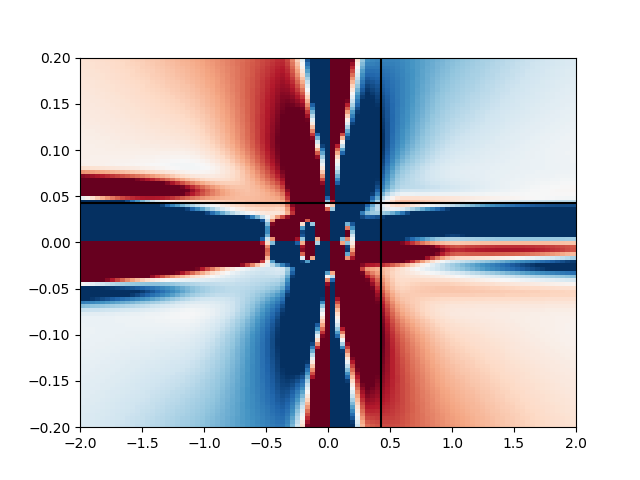

In [136]:
fig, ax = plt.subplots()

im = ax.pcolormesh(nd/1e16, Dd/1e9, alphad, cmap='RdBu', vmin=vmin, vmax=vmax)
# im = ax.pcolormesh(nd/1e16, Dd/1e9, alphad*nd**2, cmap='RdBu', vmin=0, vmax=5e33)
i, j = 60,60
ax.axvline(nd[i]/1e16, c='k')
ax.axhline(Dd[j]/1e9, c='k')
# im = ax.pcolormesh(ns/1e16, Ds/1e9, alphad, cmap='RdBu', vmin=vmin, vmax=vmax)

In [139]:
# d = "dense"
nd = np.linspace(0, 2, 100)*1e16
Dd = np.linspace(0, 0.2, 100)*1e9

ndm, Ddm = np.meshgrid(nd, Dd)

alphad = s(ndm, Ddm, grid=False)
# alphad = s(ns, Ds, grid=False)

<IPython.core.display.Javascript object>


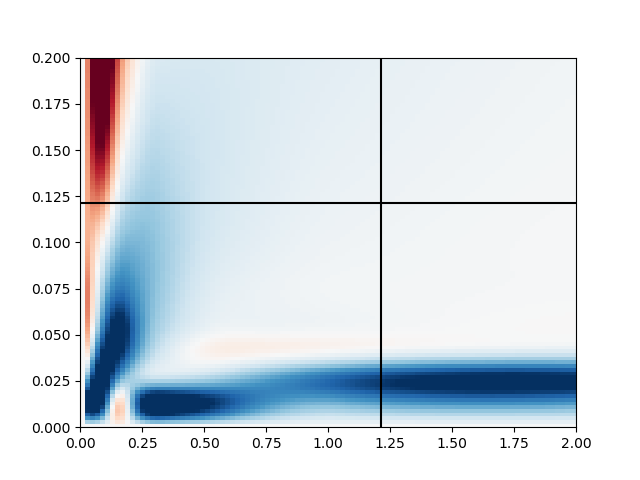

In [144]:
fig, ax = plt.subplots()

factor = 0.8
vmin = alpha.min() * factor
vmax = alpha.max() * factor

im = ax.pcolormesh(nd/1e16, Dd/1e9, alphad, cmap='RdBu', vmin=vmin, vmax=vmax)
# im = ax.pcolormesh(nd/1e16, Dd/1e9, alphad*nd**2, cmap='RdBu', vmin=0, vmax=5e33)
i, j = 60,60
ax.axvline(nd[i]/1e16, c='k')
ax.axhline(Dd[j]/1e9, c='k')
# im = ax.pcolormesh(ns/1e16, Ds/1e9, alphad, cmap='RdBu', vmin=vmin, vmax=vmax)

<IPython.core.display.Javascript object>


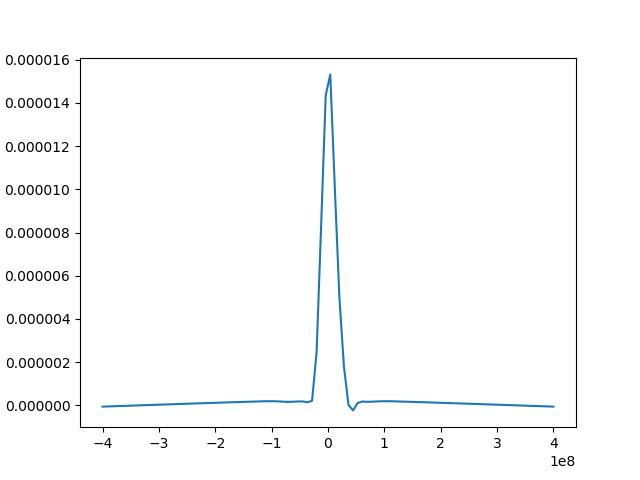

In [129]:
fig, ax = plt.subplots()
ax.plot(Dd, alphad[:, j]/Dd)

<IPython.core.display.Javascript object>


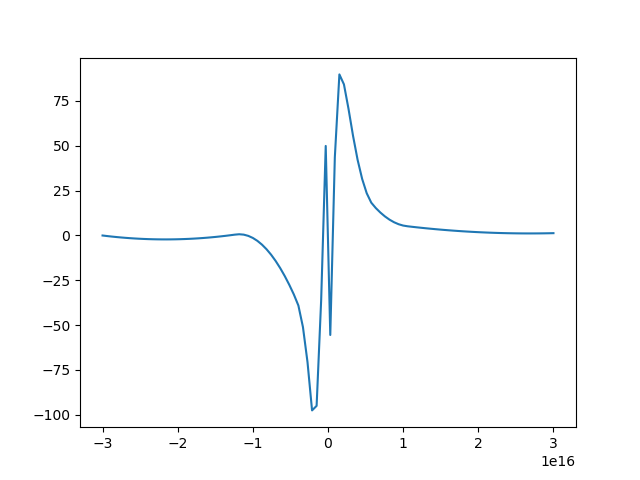

In [98]:
fig, ax = plt.subplots()
ax.plot(nd, alphad[i,:])

<IPython.core.display.Javascript object>


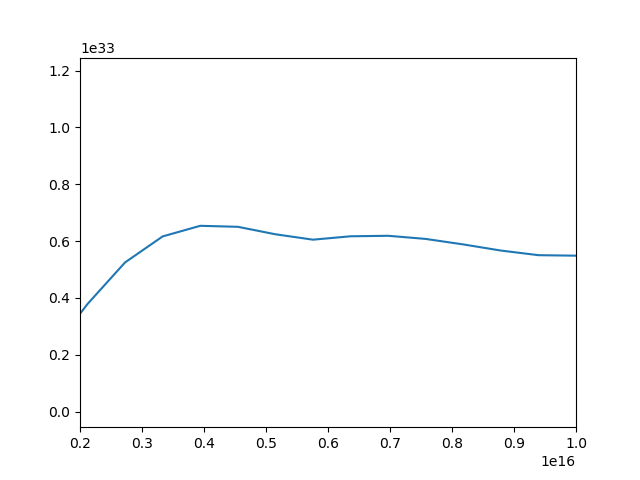

(2000000000000000.0, 1e+16)

In [109]:
fig, ax = plt.subplots()
ax.plot(nd, abs(alphad[i,:])*nd**2)
ax.set_xlim(0.2e16, 1e16)